The following additional libraries are needed to run this notebook. Note that running on Colab is experimental, please report a Github issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.17.2

Batch Normalization
:label:sec_batch_norm

Training deep neural networks is difficult. And getting them to converge in a reasonable amount of time can be tricky. In this section, we describe batch normalization, a popular and effective technique that consistently accelerates the convergence of deep networks :cite:Ioffe.Szegedy.2015. Together with residual blocks---covered later in :numref:sec_resnet---batch normalization has made it possible for practitioners to routinely train networks with over 100 layers.

Training Deep Networks
To motivate batch normalization, let us review a few practical challenges that arise when training machine learning models and neural networks in particular.

First, choices regarding data preprocessing often make an enormous difference in the final results. Recall our application of MLPs to predicting house prices (:numref:sec_kaggle_house). Our first step when working with real data was to standardize our input features to each have a mean of zero and variance of one. Intuitively, this standardization plays nicely with our optimizers because it puts the parameters a priori at a similar scale.

Second, for a typical MLP or CNN, as we train, the variables (e.g., affine transformation outputs in MLP) in intermediate layers may take values with widely varying magnitudes: both along the layers from the input to the output, across units in the same layer, and over time due to our updates to the model parameters. The inventors of batch normalization postulated informally that this drift in the distribution of such variables could hamper the convergence of the network. Intuitively, we might conjecture that if one layer has variable values that are 100 times that of another layer, this might necessitate compensatory adjustments in the learning rates.

Third, deeper networks are complex and easily capable of overfitting. This means that regularization becomes more critical.

Batch normalization is applied to individual layers (optionally, to all of them) and works as follows: In each training iteration, we first normalize the inputs (of batch normalization) by subtracting their mean and dividing by their standard deviation, where both are estimated based on the statistics of the current minibatch. Next, we apply a scale coefficient and a scale offset. It is precisely due to this normalization based on batch statistics that batch normalization derives its name.

Note that if we tried to apply batch normalization with minibatches of size 1, we would not be able to learn anything. That is because after subtracting the means, each hidden unit would take value 0! As you might guess, since we are devoting a whole section to batch normalization, with large enough minibatches, the approach proves effective and stable. One takeaway here is that when applying batch normalization, the choice of batch size may be even more significant than without batch normalization.

Formally, denoting by  an input to batch normalization () that is from a minibatch , batch normalization transforms  according to the following expression:

 
:eqlabel:eq_batchnorm

In :eqref:eq_batchnorm, 
 is the sample mean and 
 is the sample standard deviation of the minibatch . After applying standardization, the resulting minibatch has zero mean and unit variance. Because the choice of unit variance (vs. some other magic number) is an arbitrary choice, we commonly include elementwise scale parameter  and shift parameter  that have the same shape as . Note that  and  are parameters that need to be learned jointly with the other model parameters.

Consequently, the variable magnitudes for intermediate layers cannot diverge during training because batch normalization actively centers and rescales them back to a given mean and size (via 
 and 
). One piece of practitioner's intuition or wisdom is that batch normalization seems to allow for more aggressive learning rates.

Formally, we calculate 
 and 
 in :eqref:eq_batchnorm as follows:

 
 
 
 
 
Note that we add a small constant  to the variance estimate to ensure that we never attempt division by zero, even in cases where the empirical variance estimate might vanish. The estimates 
 and 
 counteract the scaling issue by using noisy estimates of mean and variance. You might think that this noisiness should be a problem. As it turns out, this is actually beneficial.

This turns out to be a recurring theme in deep learning. For reasons that are not yet well-characterized theoretically, various sources of noise in optimization often lead to faster training and less overfitting: this variation appears to act as a form of regularization. In some preliminary research, :cite:Teye.Azizpour.Smith.2018 and :cite:Luo.Wang.Shao.ea.2018 relate the properties of batch normalization to Bayesian priors and penalties respectively. In particular, this sheds some light on the puzzle of why batch normalization works best for moderate minibatches sizes in the  range.

Fixing a trained model, you might think that we would prefer using the entire dataset to estimate the mean and variance. Once training is complete, why would we want the same image to be classified differently, depending on the batch in which it happens to reside? During training, such exact calculation is infeasible because the intermediate variables for all data examples change every time we update our model. However, once the model is trained, we can calculate the means and variances of each layer's variables based on the entire dataset. Indeed this is standard practice for models employing batch normalization and thus batch normalization layers function differently in training mode (normalizing by minibatch statistics) and in prediction mode (normalizing by dataset statistics).

We are now ready to take a look at how batch normalization works in practice.

Batch Normalization Layers
Batch normalization implementations for fully-connected layers and convolutional layers are slightly different. We discuss both cases below. Recall that one key differences between batch normalization and other layers is that because batch normalization operates on a full minibatch at a time, we cannot just ignore the batch dimension as we did before when introducing other layers.

Fully-Connected Layers
When applying batch normalization to fully-connected layers, the original paper inserts batch normalization after the affine transformation and before the nonlinear activation function (later applications may insert batch normalization right after activation functions) :cite:Ioffe.Szegedy.2015. Denoting the input to the fully-connected layer by , the affine transformation by  (with the weight parameter  and the bias parameter ), and the activation function by , we can express the computation of a batch-normalization-enabled, fully-connected layer output  as follows:

Recall that mean and variance are computed on the same minibatch on which the transformation is applied.

Convolutional Layers
Similarly, with convolutional layers, we can apply batch normalization after the convolution and before the nonlinear activation function. When the convolution has multiple output channels, we need to carry out batch normalization for each of the outputs of these channels, and each channel has its own scale and shift parameters, both of which are scalars. Assume that our minibatches contain  examples and that for each channel, the output of the convolution has height  and width . For convolutional layers, we carry out each batch normalization over the  elements per output channel simultaneously. Thus, we collect the values over all spatial locations when computing the mean and variance and consequently apply the same mean and variance within a given channel to normalize the value at each spatial location.

Batch Normalization During Prediction
As we mentioned earlier, batch normalization typically behaves differently in training mode and prediction mode. First, the noise in the sample mean and the sample variance arising from estimating each on minibatches are no longer desirable once we have trained the model. Second, we might not have the luxury of computing per-batch normalization statistics. For example, we might need to apply our model to make one prediction at a time.

Typically, after training, we use the entire dataset to compute stable estimates of the variable statistics and then fix them at prediction time. Consequently, batch normalization behaves differently during training and at test time. Recall that dropout also exhibits this characteristic.

(Implementation from Scratch)
Below, we implement a batch normalization layer with tensors from scratch.

In [ ]:
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `autograd` to determine whether the current mode is training mode or
    # prediction mode
    if not autograd.is_training():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / np.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean, moving_var

We can now [create a proper BatchNorm layer.] Our layer will maintain proper parameters for scale gamma and shift beta, both of which will be updated in the course of training. Additionally, our layer will maintain moving averages of the means and variances for subsequent use during model prediction.

Putting aside the algorithmic details, note the design pattern underlying our implementation of the layer. Typically, we define the mathematics in a separate function, say batch_norm. We then integrate this functionality into a custom layer, whose code mostly addresses bookkeeping matters, such as moving data to the right device context, allocating and initializing any required variables, keeping track of moving averages (here for mean and variance), and so on. This pattern enables a clean separation of mathematics from boilerplate code. Also note that for the sake of convenience we did not worry about automatically inferring the input shape here, thus we need to specify the number of features throughout. Do not worry, the high-level batch normalization APIs in the deep learning framework will care of this for us and we will demonstrate that later.

In [ ]:
class BatchNorm(nn.Block):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims, **kwargs):
        super().__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.ctx != X.ctx:
            self.moving_mean = self.moving_mean.copyto(X.ctx)
            self.moving_var = self.moving_var.copyto(X.ctx)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma.data(), self.beta.data(), self.moving_mean,
            self.moving_var, eps=1e-12, momentum=0.9)
        return Y

[Applying Batch Normalization in LeNet]
To see how to apply BatchNorm in context, below we apply it to a traditional LeNet model (:numref:sec_lenet). Recall that batch normalization is applied after the convolutional layers or fully-connected layers but before the corresponding activation functions.

In [ ]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        BatchNorm(120, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        BatchNorm(84, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(10))

As before, we will [train our network on the Fashion-MNIST dataset]. This code is virtually identical to that when we first trained LeNet (:numref:sec_lenet). The main difference is the larger learning rate.

loss 0.263, train acc 0.904, test acc 0.855
310.7 examples/sec on cpu(0)


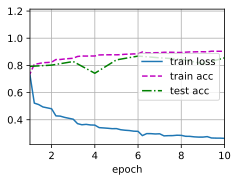

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Let us [have a look at the scale parameter gamma and the shift parameter beta] learned from the first batch normalization layer.

In [ ]:
net[1].gamma.data().reshape(-1,), net[1].beta.data().reshape(-1,)

(array([3.0818079, 1.3470196, 3.044723 , 2.720586 , 2.791078 , 4.5701604]),
 array([ 3.2929316 ,  2.0216115 , -2.6901865 ,  1.0613744 ,  0.08528686,
         2.69379   ]))

[Concise Implementation]
Compared with the BatchNorm class, which we just defined ourselves, we can use the BatchNorm class defined in high-level APIs from the deep learning framework directly. The code looks virtually identical to our implementation above.

In [ ]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(10))

Below, we [use the same hyperparameters to train our model.] Note that as usual, the high-level API variant runs much faster because its code has been compiled to C++ or CUDA while our custom implementation must be interpreted by Python.

loss 0.276, train acc 0.898, test acc 0.711
2256.3 examples/sec on cpu(0)


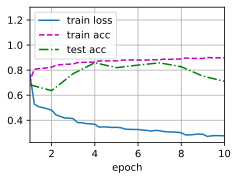

In [ ]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())